In [14]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# Author: baoyi
# Datetime: 2020/5/20 21:21

import geopandas as gpd
import pandas as pd
import os
import numpy as np


def cal_data(city):
    """
    calculate the subway ms on grid scale
    :param city:
    :return:
    """
    grid_path = f'../../Building/result/{city}/{city}.shp'
    line_path = f'./data/{city}/{city}.shp'
    station_path = f'./data/{city}/{city}_station.shp'

    grid_shp = gpd.read_file(grid_path)
    line_shp = gpd.read_file(line_path, encoding='utf-8')
    station_shp = gpd.read_file(station_path, encoding='utf-8')

    line_shp.crs = "EPSG:4326"
    line_shp = line_shp.to_crs(crs='EPSG:3857')
    station_shp.crs = 'EPSG:4326'
    station_shp = station_shp.to_crs(crs='EPSG:3857')

    # calculate the line
    print(line_shp.head())
    line_shp.plot()
    print(grid_shp.head())
    line_intersection = gpd.overlay(line_shp, grid_shp, how='intersection')
    line_intersection['inter_length'] = line_intersection.length

    subway_mci = pd.read_csv('./mci/subway_mci.csv')
    subway_mci.fillna(0, inplace=True)

    # create dir if not exist
    if not os.path.exists(f'grid/{city}'):
        os.mkdir(f'grid/{city}')

    line_intersection['Cement'] = line_intersection['inter_length'] * subway_mci[0:1]['Cement'][0] / 1000
    line_intersection['Steel'] = line_intersection['inter_length'] * float(subway_mci[0:1]['Steel'][0]) / 1000
    line_intersection['Total'] = line_intersection['inter_length'] * subway_mci[0:1]['Total'][0] / 1000

    out = line_intersection[['id', 'line', 'inter_length', 'Cement', 'Steel', 'Total']].groupby('id')
    out = out.agg(np.sum).reset_index()
    out.to_csv(f'./grid/{city}/{city}_line_grid.csv', index=False)

    # calculate the station
    station_intersection = gpd.sjoin(station_shp, grid_shp, op='intersects')

    count = len(station_intersection['line'])
    station_intersection['Cement'] = [subway_mci[1:2]['Cement'][1]] * count
    station_intersection['Steel'] = [subway_mci[1:2]['Steel'][1]] * count
    station_intersection['Gravel'] = [subway_mci[1:2]['Gravel'][1]] * count
    station_intersection['Sand'] = [subway_mci[1:2]['Sand'][1]] * count
    station_intersection['Asphalt'] = [subway_mci[1:2]['Asphalt'][1]] * count
    station_intersection['Copper'] = [subway_mci[1:2]['Copper'][1]] * count
    station_intersection['Total'] = [subway_mci[1:2]['Total'][1]] * count

    s_out = station_intersection[
        ['id', 'line', 'Cement', 'Steel', 'Gravel', 'Sand', 'Asphalt', 'Copper', 'Total']].groupby('id')

    s_out = s_out.agg(np.sum).reset_index()
    s_out.to_csv(f'./grid/{city}/{city}_station_grid.csv', index=False)

    # line grid to shape
    line_grid_shp = grid_shp.merge(out, on='id')
    line_grid_shp.to_file(f'./grid/{city}/{city}_line.shp')

    # station grid to shape
    station_grid_shp = grid_shp.merge(s_out, on='id')
    station_grid_shp.to_file(f'./grid/{city}/{city}_station.shp')

       line                                           geometry
0  11号线/机场线  LINESTRING (12669817.659 2606326.263, 12670894...
1   1号线/罗宝线  LINESTRING (12703064.198 2575853.509, 12703091...
2   2号线/蛇口线  LINESTRING (12678472.951 2569528.266, 12680122...
3   3号线/龙岗线  LINESTRING (12695529.713 2573954.786, 12695821...
4   4号线/龙华线  LINESTRING (12697563.134 2573884.837, 12697189...
   raster_val  id                                           geometry
0    0.695412   1  POLYGON ((12664215.535 2614643.688, 12664679.3...
1    0.423163   2  POLYGON ((12664679.366 2614643.688, 12665143.1...
2    0.755546   3  POLYGON ((12665143.197 2614643.688, 12665607.0...
3    0.664915   4  POLYGON ((12665607.029 2614643.688, 12666070.8...
4    0.485480   5  POLYGON ((12666070.860 2614643.688, 12666534.6...


TypeError: overlay only takes GeoDataFrames with (multi)polygon  geometries.

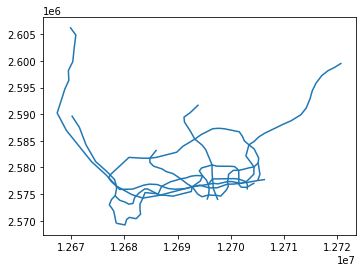

In [15]:
city = 'shenzhen'
cal_data(city)

                                            geometry
0  POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1....
1  POLYGON ((1.00000 1.00000, 2.00000 1.00000, 2....
0    0.707107
1    0.000000
dtype: float64
0    3.261496
dtype: float64


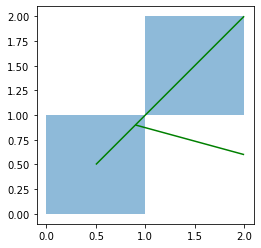

In [28]:
from shapely.geometry import Polygon, LineString
import geopandas as gpd
import matplotlib.pyplot as plt

polygon1 = Polygon([(0, 0), (1, 0), (1, 1), (0, 1), (0, 0)])
polygon2 = Polygon([(1, 1), (2, 1), (2, 2), (1, 2), (1, 1)])
line1 = LineString([(0.5, 0.5), (2, 2)])
line2 = LineString([(0.9, 0.9), (2, 0.6)])


poly_gdf = gpd.GeoDataFrame(geometry=[polygon1, polygon2])
print(poly_gdf.head())
line_gdf = gpd.GeoDataFrame(geometry=[line1, line2])
lineas_geo=gpd.GeoDataFrame(geometry=[line_gdf.unary_union])

fig, ax = plt.subplots()
poly_gdf.plot(ax=ax, alpha=0.5)
line_gdf.plot(ax=ax, color='green')

difference = line_gdf.difference(poly_gdf)
intersection = line_gdf.intersection(poly_gdf)
print(intersection.length)
print(lineas_geo.length)